In [1]:
import numpy as np
import pylab as plt

import sys
sys.path.append('../scripts')
import emission_line_model as elm

from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D

In [2]:
lines = ["OII_DOUBLET", "HGAMMA", "HBETA", "OIII_4959", "OIII_5007", "NII_6548",\
         "HALPHA", "NII_6584", "SII_6716", "SII_6731"]

model = elm.EmissionLineModel(path_to_model='../models/params_of_model_with_luminosity.npy')

# Load data. These are in lists because for each emission line the data set is slightly different (e.g. different number of objects)
obs_ews = [] # Equivalent widths
obs_ivars_ews = [] # Inverse variances on EWs
pred_ews = []

for l in range(len(lines)):
    line_obs_ews = np.load('../data/test_set_ews_'+lines[l]+'.npy')
    line_obs_ew_ivars = np.load('../data/test_set_ew_ivars_'+lines[l]+'.npy')
    line_obs_continuum_colors = np.load('../data/test_set_continuum_colors_'+lines[l]+'.npy')
    line_obs_continuum_luminosities = np.load('../data/test_set_continuum_luminosities_'+lines[l]+'.npy')

    obs_ews.append(line_obs_ews)
    obs_ivars_ews.append(line_obs_ew_ivars)
    predictions = model.predict(colors=line_obs_continuum_colors, luminosities=line_obs_continuum_luminosities)
    pred_ews.append(predictions[lines[l]])

I0000 00:00:1742788921.941859       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
# since each line test set has slighly different objects, we need to find all the common objects to take line ratios
# this will be done using the target_ids

bpt_lines = [2, 4, 6, 7] # indices of the lines to use for BPT diagram

target_ids = []
for l in range(len(bpt_lines)):
    target_ids.append(np.load('../data/test_set_target_ids_'+lines[bpt_lines[l]]+'.npy'))
    target_ids[l] = target_ids[l][:int(0.5*len(target_ids[l]))]
join = list(set(target_ids[0]) & set(target_ids[1]) & set(target_ids[2]) & set(target_ids[3]))
n_bpt = len(join)
print('number of common galaxies: ' + str(n_bpt))

# b is used to store the indices of the common galaxies for each line set. 4 arrays in total, 1 array for each line.
b = []
for l in range(len(bpt_lines)):
    sorter = np.argsort(target_ids[l])
    b.append(sorter[np.searchsorted(target_ids[l], join, sorter = sorter)][:n_bpt])
    
o3_hb_obs = np.log10(obs_ews[4][b[1]]/obs_ews[2][b[0]])
n2_ha_obs = np.log10(obs_ews[7][b[3]]/obs_ews[6][b[2]])

o3_hb_pred = np.log10(pred_ews[4][b[1]]/pred_ews[2][b[0]])
n2_ha_pred = np.log10(pred_ews[7][b[3]]/pred_ews[6][b[2]])

print(f'number of common objects is {len(o3_hb_obs)}')

number of common galaxies: 26695
number of common objects is 26695


/var/folders/6b/1r00mfq14993xp_43jcfqrgc0000gp/T/ipykernel_25658/3714997254.py:23: RuntimeWarning: invalid value encountered in log10
  o3_hb_pred = np.log10(pred_ews[4][b[1]]/pred_ews[2][b[0]])
/var/folders/6b/1r00mfq14993xp_43jcfqrgc0000gp/T/ipykernel_25658/3714997254.py:24: RuntimeWarning: invalid value encountered in log10
  n2_ha_pred = np.log10(pred_ews[7][b[3]]/pred_ews[6][b[2]])


In [4]:
# add noise on the EWs and recalculate the ratios

pred_ews_noisy = []
for l in range(len(lines)):
    pred_ews_noisy.append(np.random.normal(loc=pred_ews[l], scale=np.sqrt(1/obs_ivars_ews[l])))

o3_hb_pred_noisy = np.log10(pred_ews_noisy[4][b[1]]/pred_ews_noisy[2][b[0]])
n2_ha_pred_noisy = np.log10(pred_ews_noisy[7][b[3]]/pred_ews_noisy[6][b[2]])

/var/folders/6b/1r00mfq14993xp_43jcfqrgc0000gp/T/ipykernel_25658/4285982630.py:7: RuntimeWarning: invalid value encountered in log10
  o3_hb_pred_noisy = np.log10(pred_ews_noisy[4][b[1]]/pred_ews_noisy[2][b[0]])
/var/folders/6b/1r00mfq14993xp_43jcfqrgc0000gp/T/ipykernel_25658/4285982630.py:8: RuntimeWarning: invalid value encountered in log10
  n2_ha_pred_noisy = np.log10(pred_ews_noisy[7][b[3]]/pred_ews_noisy[6][b[2]])


In [5]:
# function to plot the BPT

def bpt_plot(ax=None, x_obs=None, y_obs=None, x_fit=None, y_fit=None, quantiles = (0.1,0.4,0.7,1),
             fit_color='green', obs_color='black'):

    # meshgrid to do gaussian kde and obtain the contours
    x_plot = np.linspace(-1.5,1,100)
    y_plot = np.linspace(-1.2,1,100)
    X,Y =  np.meshgrid(x_plot,y_plot)
    positions = np.vstack([X.ravel(),Y.ravel()])
    if x_fit is None: # if plotting only observed data
        select = np.isfinite(x_obs) * np.isfinite(y_obs) 
        x_obs, y_obs = x_obs[select], y_obs[select] 
    else:
        select = np.isfinite(x_obs) * np.isfinite(y_obs) * np.isfinite(x_fit) * np.isfinite(y_fit)
        x_obs, y_obs, x_fit, y_fit = x_obs[select], y_obs[select], x_fit[select], y_fit[select]
    
    if x_fit is not None:
        x_fit = np.clip(x_fit, a_min=-2, a_max=2)
        y_fit = np.clip(y_fit, a_min=-2, a_max=2)

    xy = np.vstack([x_obs,y_obs])
    obs_kde = gaussian_kde(xy)
    b_obs = obs_kde.factor
    z_obs = obs_kde(xy)
    f_obs = np.reshape(obs_kde(positions).T, X.shape)

    ax.contour(X, Y, f_obs, levels=np.quantile(z_obs,quantiles), colors=obs_color, linewidths=3)

    if x_fit is not None: # also plot the predicted contours
        xy_fit = np.vstack([x_fit,y_fit])
        fit_kde = gaussian_kde(xy_fit)
        b_fit = fit_kde.factor
        z_fit = fit_kde(xy_fit)
        f_fit = np.reshape(fit_kde(positions).T, X.shape)
        ax.contour(X, Y, f_fit, levels=np.quantile(z_fit,quantiles), colors=fit_color, linewidths=3, linestyles='solid')

    # add the k01 and k03 lines
    x = np.arange(-2,0,0.1)
    x2 = np.arange(-2,0.21,0.1)
    #ax.plot(x, 0.61/(x+0.08) + 1.1, color = 'k', linewidth = 3, alpha = 0.3)
    ax.plot(x, 0.61/(x-0.05)+1.3, color = 'k', label = 'Ka03', linewidth=4, alpha=.5)
    ax.plot(x2, 0.61/(x2-0.47)+1.19, color = 'k', ls = '--', label = 'ka01', linewidth=4, alpha=.5)
    ax.grid()
    ax.set_xlim([-1.5,1])
    ax.set_ylim([-1.2,1])

    return ax

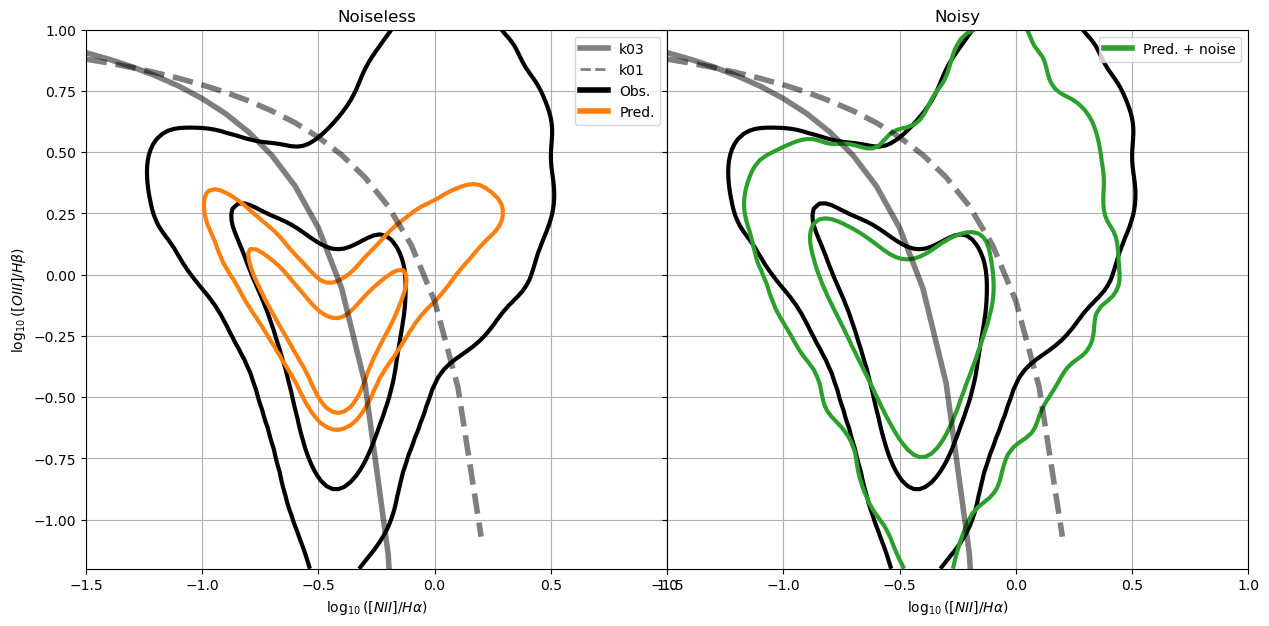

In [6]:
# plotting the noiseless and noisy BPT. It takes a while when plotting all points.
s = np.isfinite(o3_hb_obs) * np.isfinite(n2_ha_obs) * np.isfinite(o3_hb_pred_noisy) * np.isfinite(n2_ha_pred_noisy)
fig, ax = plt.subplots(ncols=2, figsize=(15,7), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
ax[0] = bpt_plot(ax=ax[0], x_obs=n2_ha_obs[s], y_obs=o3_hb_obs[s], x_fit=n2_ha_pred[s], y_fit=o3_hb_pred[s], quantiles=(1-0.95, 1-0.68), fit_color='tab:orange')
ax[0].set_xlabel(r'$\log_{10}([NII]/H\alpha)$')
ax[0].set_ylabel(r'$\log_{10}([OIII]/H\beta)$')
ax[0].set_title('Noiseless')

ax[1] = bpt_plot(ax=ax[1], x_obs=n2_ha_obs[s], y_obs=o3_hb_obs[s], x_fit=n2_ha_pred_noisy[s], y_fit=o3_hb_pred_noisy[s], quantiles=(1-0.95, 1-0.68), fit_color='tab:green')
ax[1].set_xlabel(r'$\log_{10}([NII]/H\alpha)$')
ax[1].set_title('Noisy')

legend_elements = [Line2D([0],[0], color='k', alpha=.5, linewidth=4, ls='-', label='k03'),
                   Line2D([0],[0], color='k', alpha=.5, linewidth=2, ls='--', label='k01'),
                   Line2D([0],[0], color='k', linewidth=4, ls='-', label='Obs.'),
                   Line2D([0],[0], color='tab:orange', linewidth=4, ls='-', label='Pred.')]  
ax[0].legend(handles=legend_elements, loc='upper right', prop={'size': 10})
legend_elements2 = [Line2D([0],[0], color='tab:green', linewidth=4, ls='-', label='Pred. + noise')]  
ax[1].legend(handles=legend_elements2, loc='upper right', prop={'size': 10})